In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
import osmnx as ox
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

from scripts.data_preparation import *


In [2]:
df_bol = pd.read_csv('../data/traffic_data/bologna_traffic_time_series_v3.csv')  # hourly data
df_bol['datetime'] = pd.to_datetime(df_bol['datetime'], format='mixed')

df_regional = pd.read_csv('../data/traffic_data/regional_traffic_count_cleaned_v2.csv')
bologna_meta = pd.read_csv('../data/traffic_data/bologna_traffic_metadata.csv',sep=';')
regional_meta = gpd.read_file('../data/traffic_data/filtered_regional_stations.geojson')
bologna_nodes = gpd.read_file('../data/traffic_data/rifter_nodi_pt/rifter_nodi_pt.shp')
bologna_meta['geometry'] = bologna_meta.apply(lambda row: Point(row['longitudine'], row['latitudine']), axis=1)


In [3]:
# Air quality data
df_pm10 = pd.read_csv('../data/air_quality_2024_bologna/PM10_daily.csv')
df_pm25 = pd.read_csv('../data/air_quality_2024_bologna/PM25_daily.csv')
df_no2 = pd.read_csv('../data/air_quality_2024_bologna/NO2_hourly.csv') # hourly data

stations_df = gpd.read_file('../data/air_quality_2024_bologna/stations.geojson')
bologna_gdf = ox.geocode_to_gdf('Bologna, Italy')

Step 1: Preparing traffic data...
  - Combined traffic records: 7478882

Step 2: Creating buffer zones...
  - Total zones created: 15
  - Zones per station: 3

Step 3: Assigning traffic to zones...
  - Assigned traffic records: 4479930

Step 4: Calculating weighted traffic...

Step 5: Aggregating to station level...
  - Station-hour records: 43920

Step 6: Merging with air quality data...

--- Debugging merge process ---
Traffic stations: ['DE AMICIS', 'GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'SAN LAZZARO', 'VIA CHIARINI']
NO2 stations available: ['DE AMICIS', 'GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'SAN LAZZARO', 'VIA CHIARINI']

Processed data shapes:
NO2: (43920, 3)

Station overlap:
Traffic ∩ NO2: {'DE AMICIS', 'VIA CHIARINI', 'PORTA SAN FELICE', 'SAN LAZZARO', 'GIARDINI MARGHERITA'}

After NO2 merge: (43920, 17)

Final dataset shape: (43920, 17)
Records with NO2 data: 43609
  - Merged records: 43920
(43920, 17)
    datetime         station_name  Light_Count  Medium_Count  Hea

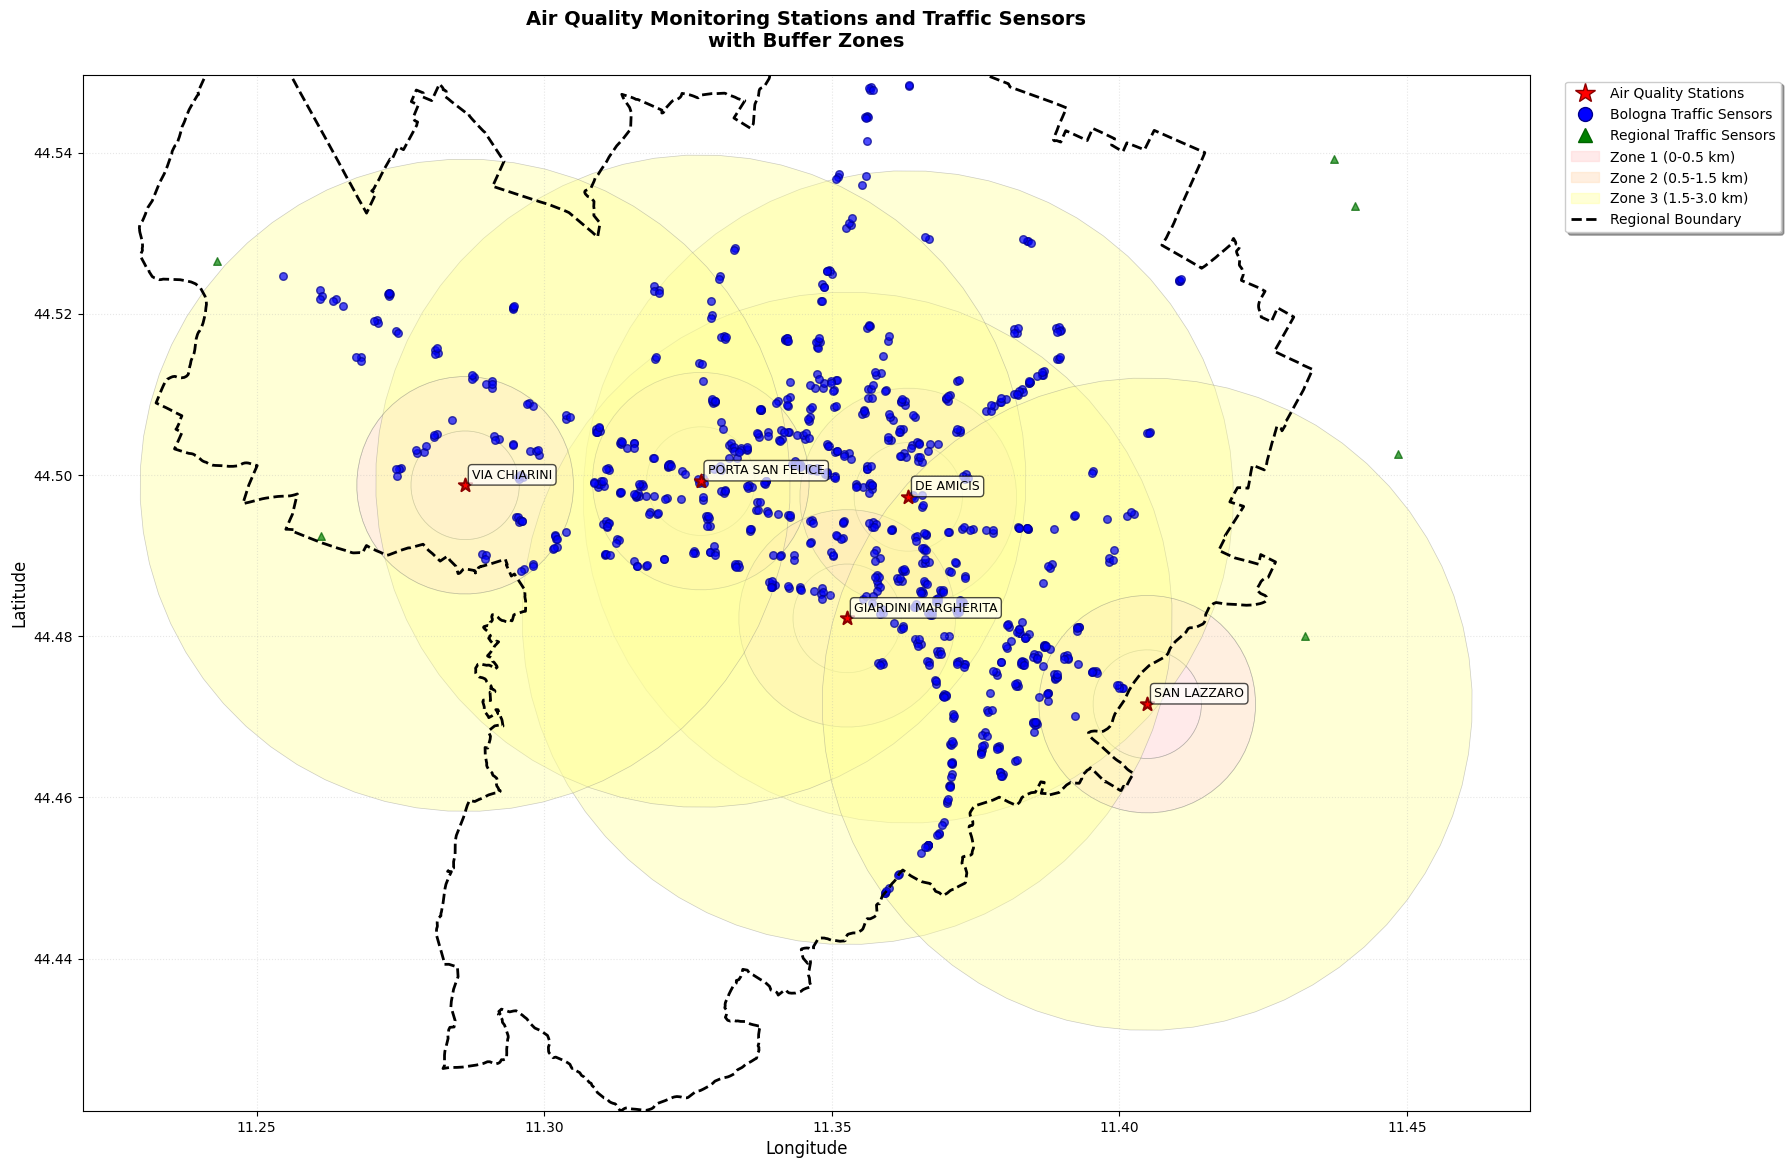

In [4]:
results = process_traffic_air_quality_data(
    df_bol, df_regional, bologna_meta, regional_meta,
    stations_df, df_no2, df_pm10, df_pm25,
    zone_distances_km=[0.75, 1.5, 4.5],
    bologna_gdf=bologna_gdf
)

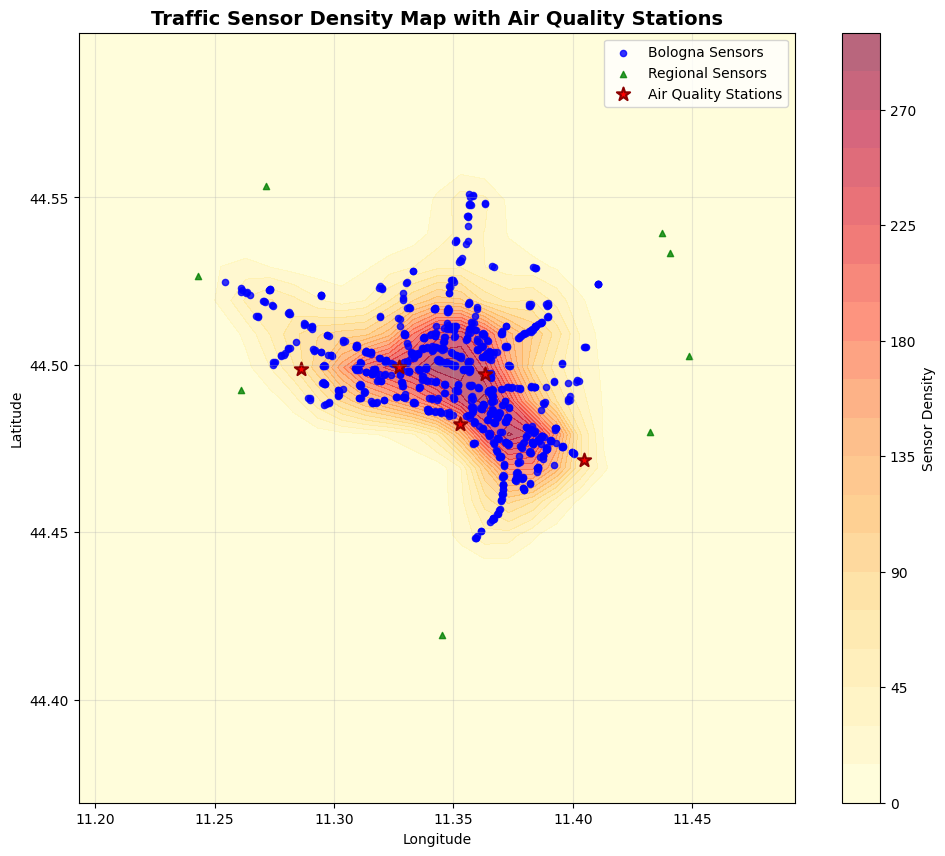

In [5]:
fig = plot_sensor_density_map(bologna_meta, regional_meta, stations_df, 
                          grid_size=0.01, save_path=None)

In [6]:
results.keys()

dict_keys(['final_dataset', 'zone_summary', 'buffer_zones', 'traffic_with_zones'])

In [7]:
final_df = results['final_dataset']

In [10]:
for item in results.keys():
    if isinstance(results[item], pd.DataFrame):
        print(f"{item} shape: {results[item].shape}")
    elif isinstance(results[item], gpd.GeoDataFrame):
        print(f"{item} shape: {results[item].shape}, crs: {results[item].crs}")
    else:
        print(f"{item}: {type(results[item])}")

final_dataset shape: (43598, 43)
zone_summary shape: (15, 11)
buffer_zones shape: (15, 7)
traffic_with_zones shape: (4479930, 20)


In [ ]:
results['traffic_with_zones'].to_parquet(
    '../data/traffic_data/processed_data/traffic_with_zones.parquet',
    compression='snappy'  
)

In [8]:
final_df.head()

,datetime,station_name,Light_Count,Medium_Count,Heavy_Count,total_vehicles,weighted_light,weighted_medium,weighted_heavy,weighted_total,...,traffic_lag_24h,NO2_lag_24h,traffic_rolling_mean_3h,NO2_rolling_mean_3h,traffic_rolling_mean_6h,NO2_rolling_mean_6h,traffic_rolling_mean_12h,NO2_rolling_mean_12h,traffic_rolling_mean_24h,NO2_rolling_mean_24h
0,2024-01-01 00:00:00,DE AMICIS,12889,551,160,13600,8300.500000,885.416667,410.666667,9596.583333,...,NaN,NaN,9596.583333,23.000000,9596.583333,23.0,9596.583333,23.0,9596.583333,23.0
5,2024-01-01 01:00:00,DE AMICIS,21977,933,280,23190,13399.833333,1420.416667,676.000000,15496.250000,...,NaN,NaN,12546.416667,19.000000,12546.416667,19.0,12546.416667,19.0,12546.416667,19.0
10,2024-01-01 02:00:00,DE AMICIS,16529,704,210,17443,10467.833333,1112.083333,524.000000,12103.916667,...,NaN,NaN,12398.916667,17.000000,12398.916667,17.0,12398.916667,17.0,12398.916667,17.0
15,2024-01-01 03:00:00,DE AMICIS,11824,504,146,12474,7225.166667,769.583333,350.666667,8345.416667,...,NaN,NaN,11981.861111,13.666667,11385.541667,16.0,11385.541667,16.0,11385.541667,16.0
20,2024-01-01 04:00:00,DE AMICIS,7453,314,94,7861,4711.500000,497.083333,234.000000,5442.583333,...,NaN,NaN,8630.638889,13.666667,10196.950000,15.8,10196.950000,15.8,10196.950000,15.8
